## In this notebook, you will implement a two-layer neural network model and stochastic gradient descent with momentum in numpy to classify CIFAR-10 images.

In [2]:
# load libraries
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import tensorflow as tf

# load CIFAR-10 data
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

# preprocess the data
x_train = x_train.reshape(x_train.shape[0], -1).astype('float')
x_test = x_test.reshape(x_test.shape[0], -1).astype('float')
y_train = y_train.squeeze()
y_test = y_test.squeeze()

x_train = x_train - x_train.mean(axis=1, keepdims=True)
x_train = x_train / x_train.std(axis=1, keepdims=True)
x_test = x_test - x_test.mean(axis=1, keepdims=True)
x_test = x_test / x_test.std(axis=1, keepdims=True)

170498071/170498071 [==============================] - 5s 0us/step


# Implement the forward and backward function for a two-layer neural network

In [3]:
class FullyConnectedNet():
  def __init__(self, hidden_dim, input_dim=3072, num_classes=10):
    super(FullyConnectedNet, self).__init__()
    self.params = {}
    self.params['W1'] = np.random.randn(input_dim, hidden_dim)/np.sqrt(input_dim/2)
    self.params['b1'] = np.zeros(hidden_dim)
    self.params['W2'] = np.random.randn(hidden_dim, num_classes)/np.sqrt(hidden_dim/2)
    self.params['b2'] = np.zeros(num_classes)
    self.grads = {}
    self.grads['W1'] = np.zeros_like(self.params['W1'])
    self.grads['b1'] = np.zeros_like(self.params['b1'])
    self.grads['W2'] = np.zeros_like(self.params['W2'])
    self.grads['b2'] = np.zeros_like(self.params['b2'])

  def forward(self, x):
    """Forward pass: linear -- ReLU -- linear

    Arguments:
        x: 2D numpy array of shape (batch_size, input_dim)

    Returns:
        scores: 2D numpy array of shape (batch_size, num_classes)
        cache: a tuple of numpy arrays, used for backward pass
    """
    ############################Write your code in this block (20 points)####################


    layer1 = np.matmul(x, self.params['W1']) + self.params['b1']

    layer2 = np.maximum(0, layer1)

    scores = np.matmul(layer2, self.params['W2']) + self.params['b2']

    cache = (layer1, layer2, x)



    #################################End of your code#########################################
    return scores, cache

  def backward(self, dscores, cache):
    """Backward pass

    Arguments:
        dscores: 2D numpy array of shape (batch_size, num_classes)
        cache: a tuple of numpy arrays saved from forward pass

    Returns:
        no explicit variable returned
        update self.grads['W1'], self.grads['b1'], self.grads['W2'], self.grads['b2']
    """
    #############################Write your code in this block (30 points)######################

    layer1, layer2, x = cache

    self.grads['W2'] = np.dot(layer2.T, dscores)
    self.grads['b2'] = np.sum(dscores, axis = 0)

    dscores_layer2 = np.dot(dscores, self.params['W2'].T)

    dscores_layer1 = dscores_layer2 * (layer1 > 0)

    self.grads['W1'] = np.dot(x.T, dscores_layer1)
    self.grads['b1'] = np.sum(dscores_layer1, axis=0)

    ##################################End of your code##########################################
    return

In [4]:
# The Cross Entropy Loss has been implemented for you
def cross_entropy_loss(scores, y, eps=1e-8):
  """Calculate cross entropy loss and its gradient with respect to scores

  Arguments:
      scores: 2D numpy array of shape (batch_size, num_classes), predicted class scores
      y: 1D numpy array of shape (batch_size,), true class labels (from 0 to num_classes-1)

  Returns:
      loss: scalar
      dscores: 2D numpy array of shape (batch_size, num_classes), loss's gradient with respect to scores

  """
  scores -= scores.max()
  exp = np.exp(scores)
  exp = np.maximum(exp, eps)
  logits = - scores[range(scores.shape[0]), y] + np.log(exp.sum(axis=1))
  loss = logits.mean()
  dscores = np.zeros_like(scores)
  dscores[range(scores.shape[0]), y] = -1
  dscores += exp/exp.sum(axis=1, keepdims=True)
  dscores /= scores.shape[0]
  return loss, dscores

# Implement SGD with momentum
Initialize $m^{(0)}=0$

After $k$ steps, update $m^{(k+1)}$ and $\theta^{(k+1)}$:
$$m^{(k+1)}=\beta \cdot m^{(k)} + \nabla_{\theta} $$
$$\theta^{(k+1)}=\theta^{(k)} - \alpha \cdot m^{(k+1)}$$
If you want to have a deep understanding of SGD with momentum, I recommend [this article](https://distill.pub/2017/momentum).

In [5]:
class SGD():
  def __init__(self, params, alpha, beta=0):
    """
    Arguments:
      params: a dictionary, with keys being variable names, and values numpy arrays
      alpha: learning rate as shown in the formula in above text cell
      beta: the momentum coefficient, as shown in the formula in the above text cell;
        if beta = 0, then it becomes vallina SGD; Can you figure out why?
    """
    self.params = params
    self.alpha = alpha
    self.beta = beta
    # Initially, set the momentum m = 0 for all parameters
    self.momentum = {n: np.zeros_like(p) for n, p in self.params.items()}

  def step(self, grads):
    """Perform gradient descent
    Arguments:
        grads: a dictionary, with the same keys as self.params, storing the corresponding gradients;
               for example, grads['W1'] is the gradient with respect to self.params['W1']
    Returns:
        No explicit returns
        Update self.params internally
    """
    #Hint: self.params is a dictionary of parameters,
    ###### use a for loop to iterate all the items from self.params,
    ###### use the formula in the above text cell to update each parameter;
    ###### Note self.momentum and grads are all dictionaries with the same keys as self.params
    ##############################Write your code in this block (20 points)######################


    for key in self.params:
      self.momentum[key] = self.momentum[key] * self.beta + grads[key]
      self.params[key] = self.params[key] - self.alpha * self.momentum[key]


    ###################################End of your code##########################################
    return

# Test your implementation using the following code

In [6]:
hidden_dim = 200
model = FullyConnectedNet(hidden_dim=hidden_dim)

In [7]:
y_pred, _ = model.forward(x_train)
acc_train = np.mean(y_pred.argmax(axis=1) == y_train)
y_pred, _ = model.forward(x_test)
acc_test = np.mean(y_pred.argmax(axis=1) == y_test)
print(f'Before training, training accuracy={acc_train}, test accuracy={acc_test}')

Before training, training accuracy=0.10074, test accuracy=0.1051


In [8]:
loss_history = []
acc_train_history = []
acc_val_history = []

In [9]:
num_iters = 2000
batch_size = 500
alpha = 1e-2
beta = 0.9
optimizer = SGD(model.params, alpha=alpha, beta=beta)
print_every = num_iters//20
for i in tqdm(range(num_iters), desc="Loading..."):
    idx = np.random.choice(x_train.shape[0], batch_size)
    x_batch = x_train[idx]
    y_batch = y_train[idx]
    scores, cache = model.forward(x_batch)
    loss, dscores = cross_entropy_loss(scores, y_batch)
    model.backward(dscores, cache)
    optimizer.step(model.grads)
    loss_history.append(loss.item())
    acc_train = np.mean(scores.argmax(axis=1) == y_batch)
    acc_train_history.append(acc_train.item())
    # test accuracy
    idx = np.random.choice(x_test.shape[0], batch_size)
    x_batch = x_test[idx]
    y_batch = y_test[idx]
    scores, cache = model.forward(x_batch)
    acc_val = np.mean(scores.argmax(axis=1) == y_batch)
    acc_val_history.append(acc_val.item())
    if i == 0 or i == num_iters-1 or (i+1)%print_every == 0:
        print(f'{i+1} loss={loss}, acc_train={acc_train}, acc_val={acc_val}')

Loading...:   0%|          | 1/2000 [00:00<06:56,  4.80it/s]

1 loss=3.161329093934164, acc_train=0.098, acc_val=0.112


Loading...:   5%|▌         | 102/2000 [00:13<02:32, 12.42it/s]

100 loss=1.5282520778494535, acc_train=0.476, acc_val=0.464


Loading...:   6%|▋         | 130/2000 [00:15<03:40,  8.49it/s]


KeyboardInterrupt: ignored

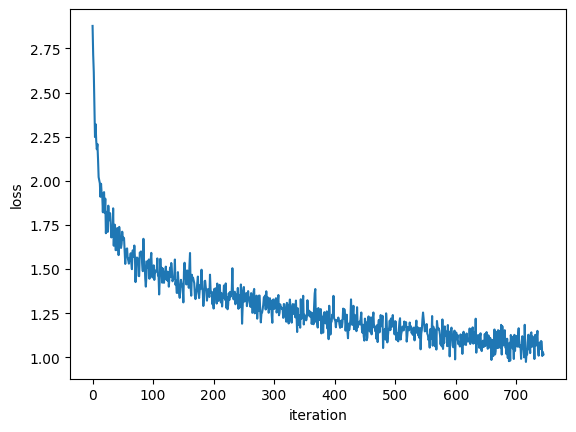

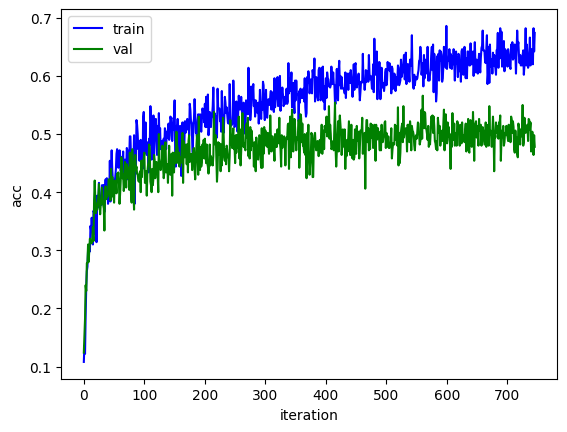

In [ ]:
plt.plot(loss_history)
plt.xlabel('iteration')
plt.ylabel('loss')
plt.show()
plt.plot(acc_train_history, 'b-', label='train')
plt.plot(acc_val_history, 'g-', label='val')
plt.xlabel('iteration')
plt.ylabel('acc')
plt.legend()
plt.show()

In [ ]:
y_pred, _ = model.forward(x_train)
acc_train = np.mean(y_pred.argmax(axis=1) == y_train)
y_pred, _ = model.forward(x_test)
acc_test = np.mean(y_pred.argmax(axis=1) == y_test)
## You should achieve a test accuracy at least 0.4
print(f'After training, training accuracy={acc_train}, test accuracy={acc_test}')

After training, training accuracy=0.64232, test accuracy=0.4998


# Try different hyperparameters: hidden_dim, lr, batch_size, num_iters, find one that can achieve the best test accuracy

In [1]:
###############Modify these hyperparameters and find the best ones (20 points)##################
###############You can write a loop to search for the best parameters if your want##############

batch_size = 400
hidden_dim = 200

#below changed alpha to speed up the learningrate, changed the num_iters to change the rate of
num_iters = 1000
alpha = 5e-2

beta = 0

#################################################################################################

model = FullyConnectedNet(hidden_dim=hidden_dim)
optimizer = SGD(model.params, alpha=alpha, beta=beta)
loss_history = []
acc_train_history = []
acc_val_history = []
print_every = num_iters//20
for i in range(num_iters):
    idx = np.random.choice(x_train.shape[0], batch_size)
    x_batch = x_train[idx]
    y_batch = y_train[idx]
    scores, cache = model.forward(x_batch)
    loss, dscores = cross_entropy_loss(scores, y_batch)
    model.backward(dscores, cache)
    optimizer.step(model.grads)
    loss_history.append(loss.item())
    acc_train = np.mean(scores.argmax(axis=1) == y_batch)
    acc_train_history.append(acc_train.item())
    # test accuracy
    idx = np.random.choice(x_test.shape[0], batch_size)
    x_batch = x_test[idx]
    y_batch = y_test[idx]
    scores, cache = model.forward(x_batch)
    acc_val = np.mean(scores.argmax(axis=1) == y_batch)
    acc_val_history.append(acc_val.item())
    if i == 0 or i == num_iters-1 or (i+1)%print_every == 0:
        print(f'{i+1} loss={loss}, acc_train={acc_train}, acc_val={acc_val}')

plt.plot(loss_history)
plt.xlabel('iteration')
plt.ylabel('loss')
plt.show()
plt.plot(acc_train_history, 'b-', label='train')
plt.plot(acc_val_history, 'g-', label='val')
plt.xlabel('iteration')
plt.ylabel('acc')
plt.legend()
plt.show()

y_pred, _ = model.forward(x_train)
acc_train = np.mean(y_pred.argmax(axis=1) == y_train)
y_pred, _ = model.forward(x_test)
acc_test = np.mean(y_pred.argmax(axis=1) == y_test)
## You should achieve a test accuracy at least 0.4
print(f'After training, training accuracy={acc_train}, test accuracy={acc_test}')

NameError: ignored